# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
from   tensorflow.keras.models                  import *
from   tensorflow.keras.layers                  import *
from   tensorflow.keras.callbacks               import *
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *
from   tensorflow.keras.utils                   import plot_model


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User library
#
from   utils.Evaluation                          import RegressionEvaluation
from   utils.LossFunctions                       import *
from   utils.CyclicLR                            import *
from   utils.WarmUpCosineDecayScheduler          import *
from   utils.Attention                           import *

# Parameters

## Data handling parameters

In [3]:
# Parameters
#
filename   = 'Data/Austin_Weather.csv'

Transformation  = True
Scaling         = 'Standard'

## Neural networks parameters

In [4]:
Lag        = 24
Horizon    =  3
#
epochs     = 100
batch_size =  32

## Neural network metrics/loss/optimizer

In [5]:
# Define NN-metrics
#
metrics = [ 
            MeanAbsolutePercentageError(name="MAPE", dtype=None),
            RootMeanSquaredError(name='RMSE', dtype=None) 
          ]

# Define Loss function
#
loss = SMAPE

# Define Opitmizer
#
optimizer = Adam(learning_rate = 1e-3)

## Neural Network callbacks

In [6]:
# Earlystopping
#
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              min_delta     = 0,
                              patience      = 30,
                              verbose       = 1, 
                              mode          = 'min', 
                              #
                              restore_best_weights = True)
  
    
# Reduce LR on Plateau
#
lrs_scheduler = ReduceLROnPlateau(monitor   = 'val_loss', 
                                  factor     = 0.5,
                                  patience   = 10)

# Cyclic LR
#
CyclicLR_scheduler = CyclicLR(base_lr   = 0.001, 
                              max_lr    = 0.006, 
                              step_size = 2000., 
                              mode      = 'triangular')
# Cosine Decay
#
CosLR__scheduler = WarmUpCosineDecayScheduler(learning_rate_base = 0.001)



# Define callbacks
#
callbacks = [earlystopping, CyclicLR_scheduler]

# Data handling

## Import data


In [7]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

[INFO] Data imported
[INFO] Time: 0.01 seconds


## Preprocess data

### Set index

In [8]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)

df.head(3)

,Temperature [Fahrenheit],DewPoint [Fahrenheit],Humidity [%],SeaLevelPressure [inches],Wind [mph],DayOfWeek,Month
Date,,,,,,,
2013-12-21,60,49.0,75.0,29.68,4.0,5,12
2013-12-22,48,36.0,68.0,30.13,6.0,6,12
2013-12-23,45,27.0,52.0,30.49,3.0,0,12


## Set 'target' features

In [9]:
# Get features
#
Features = ['Temperature [Fahrenheit]', 'DewPoint [Fahrenheit]']

### Create new features based on Date

In [10]:
# df['DayOfWeek'] = df.index.dayofweek
# df['Month']     = df.index.month

### Split Training/Testing

In [11]:
idx = int( df.shape[0] * 0.9 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

### Visualization

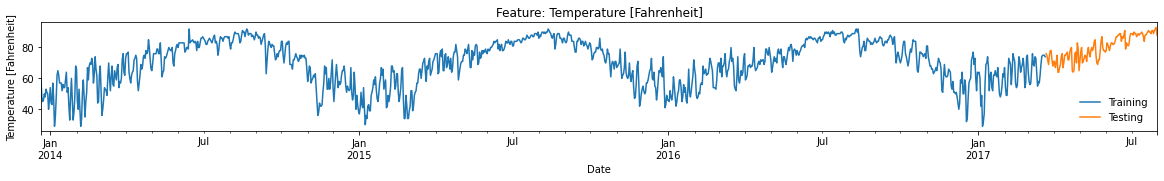

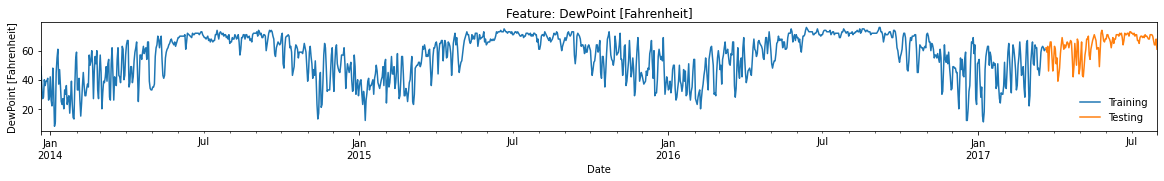

In [12]:
for feature in Features:
    
    plt.figure( figsize=(20, 2) )
    
    df_train[feature].plot( color='tab:blue' )
    df_test[feature].plot( color='tab:orange')
    
    plt.legend(['Training', 'Testing'], frameon = False)
    plt.ylabel(feature)
    plt.title('Feature: {}'.format(feature))

### Fixing Lag

In [13]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Data Transformation

In [14]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    Value = df.min().min() + 1
    
    df_train = np.log( df_train + Value)
    df_test  = np.log( df_test  + Value)   
    
else:
    print('[INFO] No data transformation applied.')    

[INFO] Data transformation applied


## Create Training/Testing data

In [15]:
def create_dataset(df = None, Lag = 1, Horizon = 12, ForecastingSeries = []):
    
    if (ForecastingSeries == []):
        ForecastingSeries = df.columns
    
    dataX, dataY = [], []
    for i in tqdm( range(df.shape[0] + 1  - Lag - Horizon) ):
        
        dataX.append( df.to_numpy()[i:(i+Lag)] )        
        dataY.append( df[ ForecastingSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        
        
    return ( np.array(dataX), np.array(dataY) )

In [16]:
trainX, trainY = create_dataset(df = df_train, 
                                Lag = Lag, 
                                Horizon = Horizon, 
                                ForecastingSeries = Features)

testX,  testY  = create_dataset(df = df_test, 
                                Lag = Lag, 
                                Horizon = Horizon, 
                                ForecastingSeries = Features)

print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 130/130 [00:00<00:00, 1891.59it/s]

Training instances:     1161
Testing instances:       130


## Scaling

In [17]:
# Transform features by scaling each feature to a given range.
#
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scalerX = MinMaxScaler()

    trainX = scalerX.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    testX  = scalerX.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scalerX = RobustScaler()
     
    trainX = scalerX.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    testX  = scalerX.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scalerX = StandardScaler()

    trainX = scalerX.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    testX  = scalerX.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    
elif (Scaling == 'None'):
    print('[WARNING] No data scaling applied.')    
else:
    print('[WARNING] Unknown data scaling. No data scaling applied.')

[INFO] Scaling: Standard


# Forecasting model: CNN-Att

## Setup model

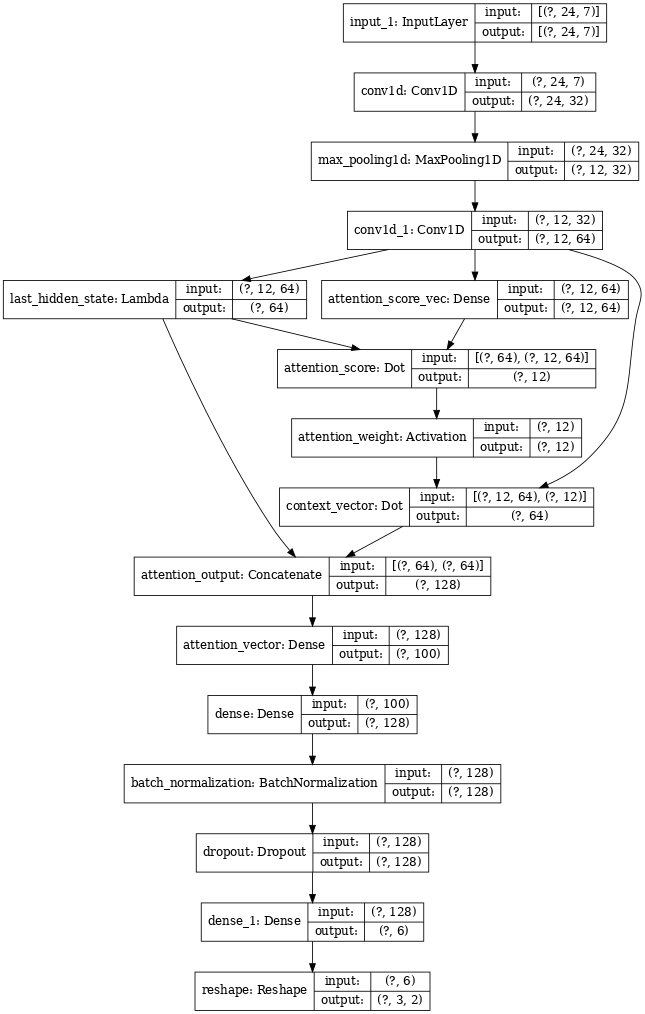

In [18]:
Input_layer = Input(shape=( trainX.shape[1], trainX.shape[2]) )   


x = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu' )(Input_layer)
x = MaxPool1D(2)(x)
x = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu' )(x)
x = Attention(100)(x)
#
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer
x = Dense(Horizon*trainY.shape[2], activation='linear')(x)
Output_layer = Reshape((Horizon, trainY.shape[2]))(x)

model = Model([Input_layer], [Output_layer])




model.compile(loss      = loss, 
              optimizer = optimizer, 
              metrics   = metrics)

plot_model(model = model, rankdir = "ΤΒ", show_shapes = True, to_file = './images/CNN-Att.png', dpi = 60)

## Training process

In [19]:
# Start clock
#
start = time.time()


score = model.fit(trainX, trainY, 
                  epochs           = epochs, 
                  batch_size       = batch_size, 
                  callbacks        = callbacks,
                  verbose          = 1, 
                  validation_split = 0.1)


# Terminate clock
#
print('[INFO] Time = %.2f' % (time.time() - start))

Epoch 1/100
33/33 [==============================] - 9s 277ms/step - loss: 1.1750 - MAPE: 108.4339 - RMSE: 5.9988 - val_loss: 1.7215 - val_MAPE: 115.5398 - val_RMSE: 4.8365
Epoch 2/100
33/33 [==============================] - 0s 8ms/step - loss: 0.8635 - MAPE: 112.5291 - RMSE: 7.4014 - val_loss: 1.6148 - val_MAPE: 142.9382 - val_RMSE: 6.5953
Epoch 3/100
33/33 [==============================] - 0s 11ms/step - loss: 0.7352 - MAPE: 109.4167 - RMSE: 7.8530 - val_loss: 1.4034 - val_MAPE: 127.5357 - val_RMSE: 6.2873
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 0.6751 - MAPE: 103.3978 - RMSE: 7.8024 - val_loss: 1.1855 - val_MAPE: 118.8501 - val_RMSE: 6.5641
Epoch 5/100
33/33 [==============================] - 0s 8ms/step - loss: 0.5983 - MAPE: 96.4547 - RMSE: 7.8487 - val_loss: 0.8061 - val_MAPE: 72.4203 - val_RMSE: 4.3093
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 0.5376 - MAPE: 89.3494 - RMSE: 7.7854 - val_loss: 0.8166 - val_MAPE: 86

## Training performance

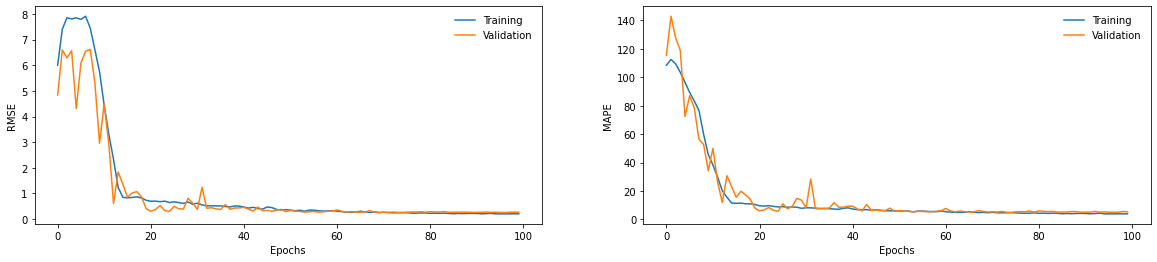

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 4))

ax[0].plot( score.history['RMSE']     );
ax[0].plot( score.history['val_RMSE'] );
ax[0].legend(['Training', 'Validation'], frameon=False);
ax[0].set_xlabel('Epochs');
ax[0].set_ylabel('RMSE');

ax[1].plot( score.history['MAPE']     );
ax[1].plot( score.history['val_MAPE'] );
ax[1].legend(['Training', 'Validation'], frameon=False);
ax[1].set_xlabel('Epochs');
ax[1].set_ylabel('MAPE');

## Save forecasting model

In [21]:
# Save model
#
model.save('models/CNN-Att.hdf5')

## Evaluation

### Get predictions

In [22]:
y_pred = model.predict( testX )

### Calculate Performance on Testing set - Prediction visualization


In [23]:
for idx, feature in enumerate(Features):
    
    print('[INFO] Feature: ', feature)
    print('------------------------------------------------')
    Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

    for i in range( Horizon ):
    
        Prices = pd.DataFrame([])        

        Prices['Real']       = testY[:,  i, idx]
        Prices['Prediction'] = y_pred[:, i, idx]

        # Apply inverse transformation   
        #
        if (Transformation == True):
            Prices = np.exp( Prices ) - Value
        
        
        
        # Evaluation
        #
        MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )
        
        # Store results
        #
        Performance_Foresting_Model['RMSE']    += [ RMSE    ]
        Performance_Foresting_Model['MAE']     += [ MAE     ]
        Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
        Performance_Foresting_Model['R2']      += [ R2      ]
        
        # Present results
        #
        print('Horizon: ', i)
        print('> RMSE:  ', RMSE)
        print('> SMAPE: ', SMAPE)
        print('> R2:    ', R2)
        print()

[INFO] Feature:  Temperature [Fahrenheit]
------------------------------------------------
Horizon:  0
> RMSE:   8.160832120689975
> SMAPE:  9.299155465719933
> R2:     -0.12270927966256662

Horizon:  1
> RMSE:   8.928485075096015
> SMAPE:  10.364745848452717
> R2:     -0.3171685382255278

Horizon:  2
> RMSE:   4.836835710425316
> SMAPE:  5.048410551178158
> R2:     0.615329829422005

[INFO] Feature:  DewPoint [Fahrenheit]
------------------------------------------------
Horizon:  0
> RMSE:   10.98339353832028
> SMAPE:  16.5870180193506
> R2:     -0.8579161231195831

Horizon:  1
> RMSE:   8.12535333702761
> SMAPE:  11.280396656239201
> R2:     -0.01564954025748233

Horizon:  2
> RMSE:   7.148957075004753
> SMAPE:  9.40631780517248
> R2:     0.21220116156293878



## Visualization

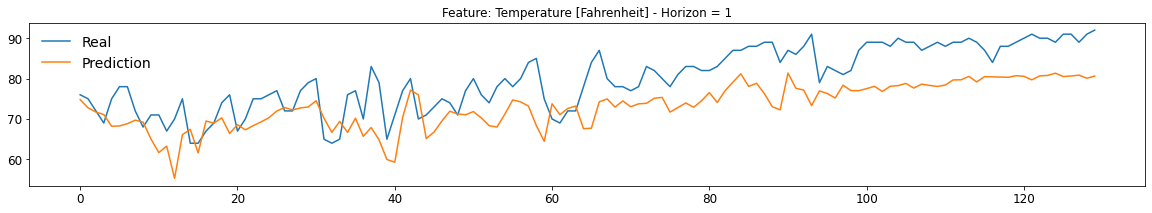

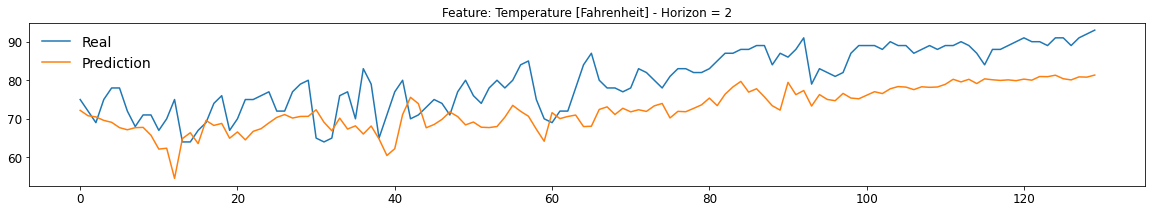

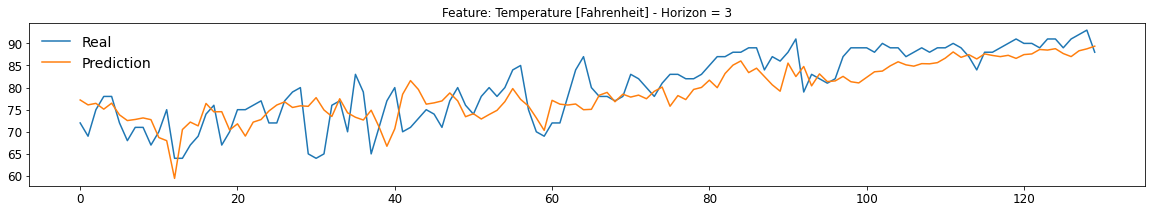

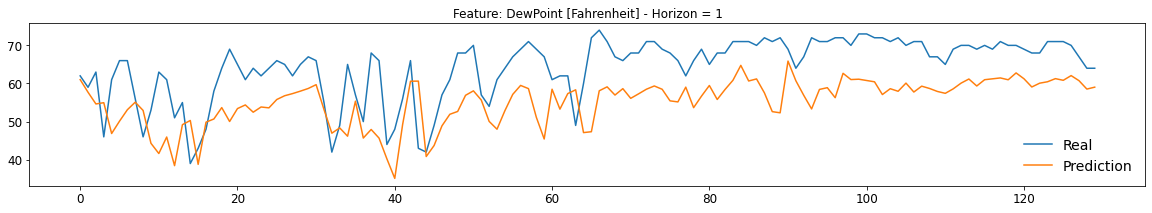

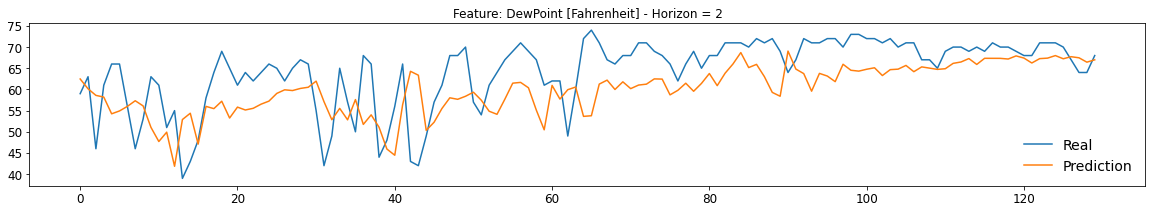

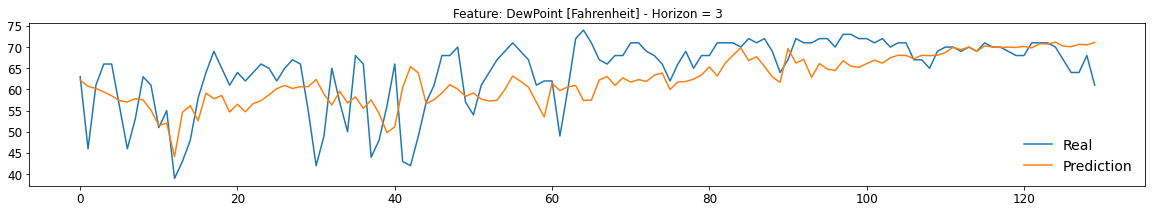

In [24]:
for idx, feature in enumerate(Features):
    
    for i in range( Horizon ):
    
        Prices = pd.DataFrame([])        

        Prices['Real']       = testY[:,  i, idx]
        Prices['Prediction'] = y_pred[:, i, idx]

        # Apply inverse transformation   
        #
        if (Transformation == True):
            Prices = np.exp( Prices ) - Value
            
            
            
        # Plot Real & Predicted values
        #
        Prices.plot( figsize = (20, 3) )
        #
        plt.title('Feature: {} - Horizon = {}'.format(feature, i+1))
        plt.legend( frameon = False, fontsize = 14)
        plt.xticks(size = 12)
        plt.yticks(size = 12)
        plt.show()        